# Final Results
---

This script outlines the final results from the thesis titled 
*Deep fMRI Encoding Models of Human Vision* by Shawn Carere. Since this repository was used for a lot of exploratory analysis, it may not be immediately clear to the reader how all of the different analysis scripts were used to obtain the results. So in this notebook we generate all figures from the
thesis to clearly outline how they were obtained. Note we also place references at the end for readability

---
---

## Chapter 3: Materials and Methods

### 3.1 - Datasets

---

The two datasets used in this work are what we refer to as the ImageNet-fMRI dataset from Horikawa et al [1] (obtained [here](http://brainliner.jp/data/brainliner/Generic_Object_Decoding)) and the MNIST-fMRI dataset from van Gerven et al. [2] (obtained [here](https://data.donders.ru.nl/collections/di/dcc/DSC_2018.00112_485?0))

The image id's can be obtained from [here](https://github.com/WeizmannVision/ssfmri2im/tree/master/KamitaniData)

#### Setup

In [1]:
# Some setup
import sys
sys.path.append('..')
from os.path import join
base_dir = '../'
# The path to the matlab file containing the fMRI data for Subject 3 from ImageNet-fMRI:
matlab_file = join(base_dir, 'kamitani_data/fmri/Subject3.mat')
# Path to the csv's containing the filenames and corresponding id's of images
test_image_ids = join(base_dir, 'kamitani_data/images/image_test_id.csv')
train_image_ids = join(base_dir, 'kamitani_data/images/image_training_id.csv')
# File containing the preprocessed images, obtained by running capsnet/misc/kamitani_image_prepare.py. Just adjust the paths of the image_generate function and set size to 112
images_npz = join(base_dir, 'kamitani_data/images/images_112.npz')
mnist_fmri_mat = join(base_dir, 'misc/69dataset_split.mat') # MNIST fMRI dataset with the same train-test split that we used

#### Load ImageNet-fMRI dataset

In [2]:
from misc import helper_functions
import numpy as np
x_train_imagenet, x_test_imagenet, y_train_imagenet, y_test_imagenet, xyz = helper_functions.load_data(
  matlab_file=matlab_file,
  test_img_ids=test_image_ids,
  train_img_ids=train_image_ids,
  images_npz=images_npz,
  roi='ROI_VC'
)
# xyz are just the coordinates of the voxels in 3d space use to map them to their spatial location in a 3d volume

# were also going to create our low-SNR validation set for the final experiment. To do this we'll load the data a bit 
# more manually as an example of how to use kamitani data handler
from misc.kamitani_data_handler import kamitani_data_handler
handler = kamitani_data_handler(matlab_file=matlab_file, test_img_csv=test_image_ids, train_img_csv=train_image_ids)
train_fmri, test_fmri, test_fmri_avg = handler.get_data(roi='ROI_VC')
del train_fmri
del test_fmri_avg
labels_train, labels = handler.get_labels(imag_data = 0)

y_test_imagenet_lowsnr = []
for i in range(50): # go through
    # y_test_noisy.append(Y_test[np.where(labels == i)[0][0]])
    y_test_imagenet_lowsnr.append(test_fmri[np.where(labels == i)[0]])
y_test_imagenet_lowsnr = np.array(y_test_imagenet_lowsnr)

2022-12-21 12:19:47.449831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load the MNIST-fMRI dataset

Note that we randomly split the data into train and validation sets.

In [3]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
mnist_fmri = loadmat(mnist_fmri_mat)
x_train_mnist = mnist_fmri['x_train']
x_test_mnist = mnist_fmri['x_test']
y_test_mnist = mnist_fmri['y_test']
y_train_mnist = mnist_fmri['y_train']
scaler = StandardScaler()
y_train_mnist = scaler.fit_transform(y_train_mnist)
y_test_mnist  = scaler.transform(y_test_mnist)

### 3.4 Model Evaluation

---

#### Metrics

In [4]:
import numpy as np
from scipy import stats

#Define metrics as functions, mainly so that they can be used for bagging
'''For all the below functions:

Args:
  y_pred: The predicted fMRI brain activity with shape (NUM_SAMPLES, NUM_VOXELS)
  y_pred: The 'ground truth' or measured fMRI brain activity with shape (NUM_SAMPLES, NUM_VOXELS)

'''

def voxel_corr(y_pred, y_true):
  '''Calculates the voxelwise correlations for each voxel

  Returns:
    vc: Array of voxelwise correlation coefficients with shape (NUM_VOXELS)
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  vc = []
  for i in range(NUM_VOXELS):
    vc.append(stats.pearsonr(y_pred[:, i], y_true[:, i])[0]) 
  return np.array(vc)

def vc_mean(y_pred, y_true):
  '''Calculates the average voxelwise correlation across all voxels

  Returns:
    vc_mean : Scalar value which is avarage voxelwise correlation across all voxels
      in y_pred/y_true
  '''
  return np.mean(voxel_corr(y_pred, y_true))

def vc_top100_mean(y_pred, y_true):
  '''Calculates the average voxelwise correlation of the 100 most highly correlated
    voxels

  Returns:
    vc_mean_top100: Scalar value which is average voxelwise correlation across the
      100 voxels with the highest voxelwise correlations
  '''
  vc = voxel_corr(y_pred, y_true)
  vc_sort = np.sort(vc)
  return np.mean(vc_sort[-100:])

def vc_pval(y_pred, y_true):
  '''Calculates the p-value significance associated with the voxelwise correlation
  coefficients

  Returns:
    p: Array of p-values for the voxelwise correlation coefficients with shape (NUM_VOXELS)
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  p = []
  for i in range(NUM_VOXELS):
    p.append(stats.pearsonr(y_pred[:, i], y_true[:, i])[1]) 
  return np.array(p)

def sample_corr(y_pred, y_true):
  '''Calculates the samplewise correlation coefficients for each sample

  Returns:
    sc: Array of samplewise correlation coefficients with shape (NUM_SAMPLES)
  '''
  NUM_SAMPLES = np.shape(y_pred)[0]
  sc = []
  for i in range(NUM_SAMPLES):
    sc.append(stats.pearsonr(y_pred[i], y_true[i])[0])
  return np.array(sc)

def sc_mean(y_pred, y_true):
  '''Calculates the average samplewise correlation across all samples

  Returns:
    sc_mean : Scalar value which is avarage samplewise correlation across all samples
      in y_pred/y_true
  '''
  return np.mean(sample_corr(y_pred, y_true))

# response sensitivity does not actually depend on y_true. but we have it as an arg so that it works with the bagging functions i already had
def response_sensitivity(y_pred, y_true): 
  '''Calculates the voxel response sensitivities for each voxel

  Returns:
    rs: Array of voxel response sensitivities with shape (NUM_VOXELS)
  '''
  return np.std(y_pred, axis=0)

def rs_mean(y_pred, y_true):
  '''Calculates average voxel response sensitivity across alll voxels

  Returns:
    rs_mean: Scalar value which is average voxel response sensitivity across all
      voxels in y-pred/y_true
  '''
  return np.mean(response_sensitivity(y_pred, y_true))

def response_weighted_corr(y_pred, y_true):
  '''Calculates the response weighted correlation for each voxel

  Returns:
    rwc: Array of response weighted correlations with shape (NUM_VOXELS)
  '''
  vc = voxel_corr(y_pred, y_true)
  rs = response_sensitivity(y_pred, y_true)
  vcrs = vc * rs
  rwc = np.sign(vcrs)*np.sqrt(abs(vcrs))
  return rwc

def rwc_mean(y_pred, y_true):
  '''Calculates the average response weighted correlation across all voxels

  Returns:
    rwc_mean: Scalar value which is averag response weighted correlation across
      all voxels in y_pred/y_true
  '''
  return np.mean(response_weighted_corr(y_pred, y_true))

def confidence_95(vals):
  '''Calculates the 95% confidence interval given repeated instances of some value
  or metric

  Args:
    vals: Array of values representing repeated observations of some metric or variable

  Returns:
    interval: The scalar magnitude of the confidence interval
  '''
  z = 1.960 # z-score for a confidence of 95%
  n = len(vals)
  return z*np.std(vals)/(np.sqrt(n))

def mse(y_pred, y_true):
  '''Calculates the mean squared error between the predictions and labels

  Returns:
    mse: Scalar value representing overall mean squared error
  '''
  diff = np.subtract(y_pred, y_true)
  return np.mean(np.square(diff))

def rwc_thresh(y_pred, y_true):
  '''Calculates the reponse weighted correlation threshold that would be used to
  differentiate intentional and unintentional voxels

  Returns:
    rwc_thresh: Scalar value representing the RWC threshold
  '''
  rwc = response_weighted_corr(y_pred, y_true)
  return abs(np.min(rwc))

def get_int_vox_idx(y_pred, y_true):
  '''Get indices of voxels classified as intentional using the RWC threshold

  Returns: 
    ind: Array of integer indices representing which voxels are above RWC threshold
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  rwc = response_weighted_corr(y_pred, y_true)
  thresh = abs(np.min(rwc))
  return np.where(rwc > thresh)[0]

def above_thresh_percentage(y_pred, y_true):
  '''Calculates the percentage of voxels above the RWC threshold, and hence
  classified as intentional

  Returns:
    ab_percent: Scalar value representing percentage of voxels above RWC thresh
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  v_int = get_int_vox_idx(y_pred, y_true)
  return len(v_int)*100/NUM_VOXELS

def rwc_skew(y_pred, y_true):
  '''Calculates the RWC skew values for each voxel

  Returns
    rwc_skew: Array of RWC skews with shape (NUM_VOXELS)
  '''
  vc = voxel_corr(y_pred, y_true)
  rs = response_sensitivity(y_pred, y_true)
  rho, phi = helper_functions.cart2pol(1 - rs, 1 - vc)
  skew = phi*(180/np.pi) - 45
  return skew

def rwc_skew_mean(y_pred, y_true):
  '''Calculates average RWC skew across all voxels

  Returns:
    rwc_skew_mean: Scalar value representing average RWC skew across all voxels
      in y_pred/y_true
  '''
  return np.mean(rwc_skew(y_pred, y_true))

#### Bagging

This section contains functions for automatically using bagging to calculate repeated estimates of a metric using bootstrap replicates. This allows us to generate confidence intervals for the metrics as well as performed statistical test of significance such as the wilcoxon signed rank test

In [5]:
NUM_BOOTSTRAP_REPLICATES = 10 # In our work we used 1000 as we found that fewer replicates resulted in too much variation. Here we put 10 as a placeholder so that script runs quickly
def boostrap_replicate(y_pred, y_true, func):
    '''Applies a function to a bootstrap replicate of the validation set

    Args:
        y_pred: The predictions from the model to be passed as the first argument to func
        y_true: The labels for y_pred set to be passed as the second argument to func
        func: Some function that takes (y_pred, y_true) as arguments and returns a scalar metric

    Returns:
        val: The output of func when given a bootstrap replicate of the data as an input
    '''
    NUM_SAMPLES = np.shape(y_pred)[0]
    data = np.stack([y_pred, y_true], axis=0)
    rng = np.random.default_rng()
    bootstrap = rng.choice(data, size=NUM_SAMPLES, replace=True, axis=1)
    val = func(bootstrap[0], bootstrap[1])
    return val

def draw_bs_replicate(y_pred, y_true, func, num):
    '''Uses bagging to calculate multiple estimates of a value using bootstrap replicates

    Args:
        y_pred: The predictions from the model to be passed as the first argument to func
        y_true: The labels for y_pred set to be passed as the second argument to func
        func: Some function that takes (y_pred, y_true) as arguments and returns a scalar metric
        num: The number of estimates to calculate, hence the number of bootstrap replicates to use

    Returns:
        vals: An array with shape (num) containing repeated calculations of the output
            from func given different randomly generated bootstrap replicates as the input
    '''
    vals = []
    for i in range(num):
        print('\r', i, end='') # tqdm leaves whitespace so we just print what iteration were on and delete it after
        val = boostrap_replicate(y_pred, y_true, func)
        vals.append(val)
    print('\r', end='') # delete the last iteration number
    return vals

---
---

## Chapter 4: Results

### 4.1 - Encoding Naturalistic Images
---

In this section we do the initial comparison of the capsule and beliy encoders on the Imagenet-fMRI dataset [1]

#### Calculate model predictions

We have the predicted activity for the beliy encoder saved into a csv, to make running this notebook easier. However, it can be obtained manually by following the instructions [here](https://github.com/WeizmannVision/ssfmri2im).

In [8]:
from pycaps.fmri_models import CapsEncoder

# Calculate capsule encoder predictions
# caps_encoder_imagenet = CapsEncoder(num_voxels=np.shape(y_test_imagenet)[1], num_output_capsules=10)
# caps_encoder_imagenet.load_weights(join(base_dir, 'trained_models/caps_encoder_test2/model_weights')).expect_partial()
# caps_pred_imagenet = caps_encoder_imagenet.predict(x_test_imagenet)

# Or load them from a csv if you want to avoid doing the training yourself
caps_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/caps_pred_imagenet.csv'), delimiter=',')

# Load Beliy encoder predictions:
beliy_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pred_imagenet.csv'), delimiter=',')


#### Figure 4.1: Visualize predictions in 3d space

To create anatomical visualizations, we first saved the 3d volumes as nifti 
(.nii.gz) files and then loaded them into FSLEyes. FSLEyes is an fMRI visualization tool. It is a part of the fMRI Software Library (FSL) which can be found [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslInstallation). Here we show how data was saved as Nifti files to be imported in FSLEyes. We use FSLEyes because it automatically aligns the fMRI voxels with the anatomical images so that we can overlay the fMRI data on top of the anatomical images. This could be done manually using the affine matrix, but it's easier to just do it with FSLEyes. Hence here we recreate Figure 4.1 without using the anatomical images as an underlay.

In [7]:
from bdpy.mri.image import export_brain_image
import nibabel
template = join(base_dir, 'kamitani_data/func_raw/sub-03_ses-perceptionTest01_task-perception_run-01_bold_preproc.nii.gz')
# Convert fMRI vectors to nibabel nifti images
# A nibabel nifti image contains the fMRI data in 3d form (dataobj), an affine matrix that mapes those voxels to 'world coordinates' and a header containing metadata
# Our 3d volumes have shape (64, 64, 50)
caps_pred_s0 = export_brain_image(caps_pred_imagenet[0, :], template=template, xyz=xyz)
beliy_pred_s0 = export_brain_image(beliy_pred_imagenet[0, :], template=template, xyz=xyz)
y_test_s0 = export_brain_image(y_test_imagenet[0, :], template=template, xyz=xyz)
caps_pred_s4 = export_brain_image(caps_pred_imagenet[4, :], template=template, xyz=xyz)
beliy_pred_s4 = export_brain_image(beliy_pred_imagenet[4, :], template=template, xyz=xyz)
y_test_s4 = export_brain_image(y_test_imagenet[4, :], template=template, xyz=xyz)

# Example on how to save fMRI nifti image as a nifti file (.nii.gz)
#nibabel.save(caps_pred_s0, 'caps_pred_s0.nii.gz')

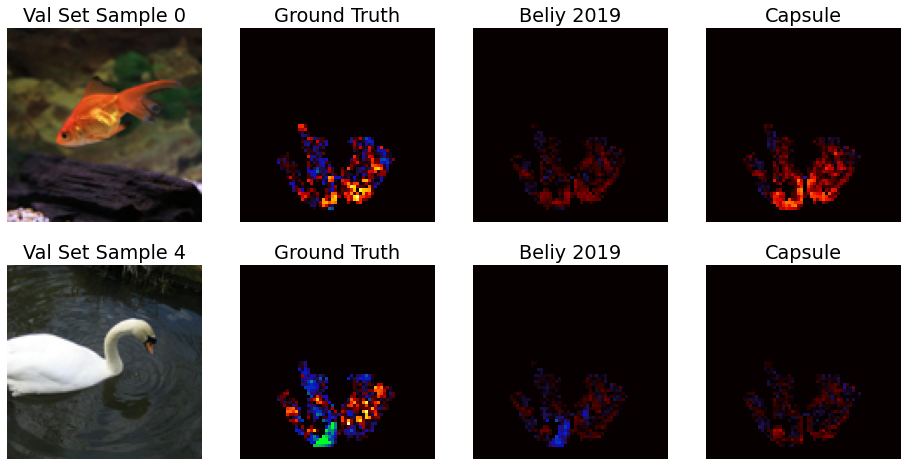

In [75]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Create the actual figure
# Images used in figure 4.1 were samples 0 and 4
fig, axes = plt.subplots(2, 4, figsize = (16, 8))
MEAN_PIXELS = [123.68, 116.779, 103.939] # Note that the mean values across each channel were subtracted from the images (this was part of the beliy image preprocessing). So we have to undo that to display them

# define color map
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
neg_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/6bluegrn_iso.cmap'), delimiter=' ')
pos_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/1hot_iso.cmap'), delimiter=' ')
cmap = colors.LinearSegmentedColormap.from_list('cold-hot', np.vstack([np.flip(neg_cmap, axis=0), pos_cmap]))

# Sample 0
# Note that if pixels are floats, imshow assumes 0-1 range, if they are integers, assumes 0-255 range
# Also note that 18 is an arbitrary slice out of the 3d volume that was chosen for the figure. It was chosen because it covers a large portion of both the lower and higher visual cortex
axes[0, 0].imshow(np.add(x_test_imagenet[0], MEAN_PIXELS).astype(int))
axes[0, 0].axis('off')
axes[0, 0].set_title('Val Set Sample 0')

axes[0, 1].imshow(np.rot90(y_test_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 1].axis('off')
axes[0, 1].set_title('Ground Truth')

axes[0, 2].imshow(np.rot90(beliy_pred_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 2].axis('off')
axes[0, 2].set_title('Beliy 2019')

axes[0, 3].imshow(np.rot90(caps_pred_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 3].axis('off')
axes[0, 3].set_title('Capsule')

# Sample 4
axes[1, 0].imshow(np.add(x_test_imagenet[4], MEAN_PIXELS).astype(int))
axes[1, 0].axis('off')
axes[1, 0].set_title('Val Set Sample 4')

axes[1, 1].imshow(np.rot90(y_test_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 1].axis('off')
axes[1, 1].set_title('Ground Truth')

axes[1, 2].imshow(np.rot90(beliy_pred_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 2].axis('off')
axes[1, 2].set_title('Beliy 2019')

axes[1, 3].imshow(np.rot90(caps_pred_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 3].axis('off')
axes[1, 3].set_title('Capsule')

plt.show()

#### Creating Naive Model for ImageNet-fMRI

In [9]:
naive_pred_imagenet = np.broadcast_to(np.mean(y_train_imagenet, axis=0), shape=y_test_imagenet.shape)
naive_pred_imagenet = np.add(naive_pred_imagenet, np.random.exponential(0.04, naive_pred_imagenet.shape))

#### Table 4.1: ImageNet-fMRI Metrics

Here we calculate various evaluation metrics on the ImageNet-fMRI dataset and use bagging to generate confidence intervals on those metrics

In [34]:
from tabulate import tabulate
metrics = [mse, vc_mean, sc_mean, rs_mean]
model_preds = [beliy_pred_imagenet, caps_pred_imagenet, naive_pred_imagenet]
model_names = ['beliy', 'capsule', 'naive']
metric_names = ['MSE', 'VC', 'SC', 'RS']
bag_metrics_imagenet_set1 = {'MSE': {}, 'VC': {}, 'SC': {}, 'RS': {}}

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred, y_test_imagenet, metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
    bag_metrics_imagenet_set1[metric_names[j]][model_names[i]] = vals
  table_text.append(row_text)

# If one wanted to save the results
# with open('imagenet_bag_metrics.pkl', 'wb') as f:
#   pickle.dump(bag_metrics_imagenet_set1, f)

print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

╒═════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│         │ MSE                │ VC                 │ SC                 │ RS                 │
╞═════════╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ beliy   │ 0.062194+-0.001129 │ 0.295619+-0.013245 │ 0.502334+-0.008838 │ 0.072828+-0.001276 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ capsule │ 0.081926+-0.002004 │ 0.083402+-0.021729 │ 0.218303+-0.013195 │ 0.056965+-0.001100 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ naive   │ 0.088883+-0.001829 │ 0.000102+-0.000879 │ 0.155406+-0.005912 │ 0.038139+-0.000128 │
╘═════════╧════════════════════╧════════════════════╧════════════════════╧════════════════════╛


### 4.2 - Encoding Handwritten Digits
---

#### Calculate model predictions

In [10]:
# Calculate capsule encoder predictions
# caps_encoder_mnist = CapsEncoder(num_voxels=np.shape(y_test_mnist)[1], num_output_capsules=2, routing='dynamic', caps_act='squash')
# caps_encoder_mnist.load_weights(join(base_dir, 'trained_models/digits_encoder_test2/model_weights')).expect_partial()
# caps_pred_mnist = caps_encoder_mnist.call(x_test_mnist)

# Or load them from csv files
caps_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/caps_pred_mnist.csv'), delimiter=',')
beliy_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pred_mnist.csv'), delimiter=',')
lcnn_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/lcnn_pred_mnist.csv'), delimiter=',')

#### Create naive model for MNIST-fMRI

In [11]:
naive_pred_mnist = np.broadcast_to(np.mean(y_train_mnist, axis=0), shape=y_test_mnist.shape)
naive_pred_mnist = np.add(naive_pred_mnist, np.random.exponential(0.04, naive_pred_mnist.shape))

#### Table 4.2: MNIST-fMRI Metrics

Calculate the various metrics on the MNIST-fMRI dataset. We also introduce an additional model called Large CNN which has the same architecture as the beliy model except the number of channels has been increased

In [36]:
from tabulate import tabulate
metrics = [mse, vc_mean, sc_mean, rs_mean]
model_preds = [beliy_pred_mnist, caps_pred_mnist, lcnn_pred_mnist, naive_pred_mnist]
model_names = ['beliy', 'capsule', 'large_cnn', 'naive']
metric_names = ['MSE', 'VC', 'SC', 'RS']
bag_metrics_mnist_set1 = {'MSE': {}, 'VC': {}, 'SC': {}, 'RS': {}}

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred, y_test_mnist, metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
    bag_metrics_mnist_set1[metric_names[j]][model_names[i]] = vals
  table_text.append(row_text)

# To save metrics if desired
# with open('mnist_bag_metrics.pkl', 'wb') as f:
#   pickle.dump(bag_metrics_mnist_set1, f)

print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

╒═══════════╤════════════════════╤═════════════════════╤═════════════════════╤════════════════════╕
│           │ MSE                │ VC                  │ SC                  │ RS                 │
╞═══════════╪════════════════════╪═════════════════════╪═════════════════════╪════════════════════╡
│ beliy     │ 1.027159+-0.024905 │ 0.143222+-0.012255  │ 0.239750+-0.022308  │ 0.060280+-0.004336 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ capsule   │ 1.006251+-0.019735 │ 0.188588+-0.014350  │ 0.235843+-0.009542  │ 0.207063+-0.004722 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ large_cnn │ 0.994404+-0.028059 │ 0.193355+-0.015978  │ 0.247836+-0.014511  │ 0.202824+-0.010922 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ naive     │ 1.086352+-0.028287 │ -0.007786+-0.001656 │ -0.010201+-0.002112 │ 0.035167+-0.000312 │


### 4.3 - Characterizing Model Behaviour
---
 Since this is a large section, we use '====' to separate distinct figures/blocks of code

================================================================================

#### Load Beliy Encoders Trained on Positive and Negative Voxel Subsets
Here we load the predictions from the encoder trained only on the negative and positive voxel subsets. We also show exactly how these subsets are determined using the voxelwise correlations of the beliy encoder trained with all of the voxels

In [12]:
beliy_imagenet_vc = voxel_corr(beliy_pred_imagenet, y_test_imagenet)
pos_vox_subset = np.where(beliy_imagenet_vc > 0)[0]
neg_vox_subset = np.where(beliy_imagenet_vc < 0)[0]

# Beliy encoder was trained seperately on the two voxel subsets defined by pos_vox_subset and neg_vox_subset.
# We load the predictions from model trained on pos_vox_subset as well as the model trained on neg_vox_subset
beliy_pv_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pv_pred_imagenet.csv'), delimiter=',')
beliy_nv_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_nv_pred_imagenet.csv'), delimiter=',')

# Calculate the voxelwise correlations for the models trained on the pos and neg subsets
beliy_pv_imagenet_vc = voxel_corr(beliy_pv_pred_imagenet, y_test_imagenet[:, pos_vox_subset])
beliy_nv_imagenet_vc = voxel_corr(beliy_nv_pred_imagenet, y_test_imagenet[:, neg_vox_subset])

####  Figure 4.2: Comparison of Beliy Encoder Trained with Different Subsets

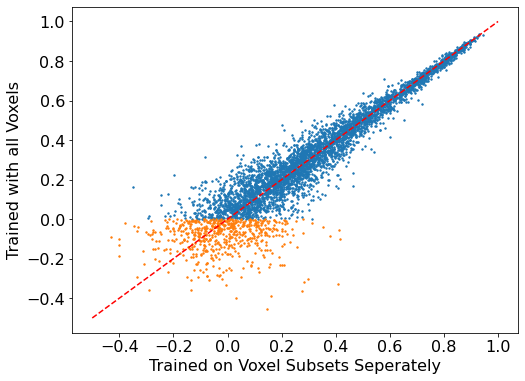

In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(8, 6))
# Plot the vc's of the model train on pos vox subset against the vc's of the model trained with all voxels
plt.scatter(beliy_pv_imagenet_vc, beliy_imagenet_vc[pos_vox_subset], s=2)
# Plot the vc's of the model train on neg vox subset against the vc's of the model trained with all voxels
plt.scatter(beliy_nv_imagenet_vc, beliy_imagenet_vc[neg_vox_subset], s=2)
plt.xlabel('Trained on Voxel Subsets Seperately')
plt.ylabel('Trained with all Voxels')
plt.plot([-0.5, 1], [-0.5, 1], '--', color='red')
plt.show()

================================================================================

================================================================================
#### Figure 4.3: Visualizing Voxelwise Correlation and Voxel Response Sensitivity in 3d Space

Again we note that for this figure we saved the desired metrics as nifti (.nii.gz) volumes and then loaded them into FSLEyes to generate the visualization of the metrics in *fMRI space* overlayed on top of the higher resolution anatomical images in *anatomical space*. Here we recreate the figure without the anatomical underlay

In [13]:
from bdpy.mri.image import export_brain_image
import nibabel
template = join(base_dir, 'kamitani_data/func_raw/sub-03_ses-perceptionTest01_task-perception_run-01_bold_preproc.nii.gz')

beliy_imagenet_vc = voxel_corr(beliy_pred_imagenet, y_test_imagenet)
caps_imagenet_vc = voxel_corr(caps_pred_imagenet, y_test_imagenet)
beliy_imagenet_rs = response_sensitivity(beliy_pred_imagenet, y_test_imagenet)
caps_imagenet_rs = response_sensitivity(caps_pred_imagenet, y_test_imagenet)

beliy_imagenet_vc_3d = export_brain_image(beliy_imagenet_vc, template=template, xyz=xyz)
caps_imagenet_vc_3d = export_brain_image(caps_imagenet_vc, template=template, xyz=xyz)
beliy_imagenet_rs_3d = export_brain_image(beliy_imagenet_rs, template=template, xyz=xyz)
caps_imagenet_rs_3d = export_brain_image(caps_imagenet_rs, template=template, xyz=xyz)

# Example on how to save fMRI nifti image as a nifti file (.nii.gz)
#nibabel.save(beliy_imagenet_vc_3d, 'beliy_imagenet_vc.nii.gz')

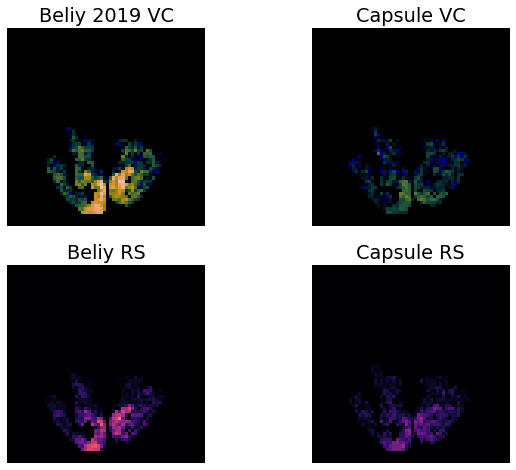

In [87]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Create the actual figure
# Images used in figure 4.1 were samples 0 and 4
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

# define color map
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

neg_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/black-blue.cmap'), delimiter=' ')
pos_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/savanna.cmap'), delimiter=' ')
magma = np.loadtxt(join(base_dir, 'analysis/cmaps/magma.cmap'), delimiter=' ')
vc_cmap = colors.LinearSegmentedColormap.from_list('vc', np.vstack([np.flip(neg_cmap, axis=0), pos_cmap]))
rs_cmap = colors.LinearSegmentedColormap.from_list('rs', magma)

axes[0, 0].imshow(np.rot90(beliy_imagenet_vc_3d.dataobj[:, :, 18]), cmap=vc_cmap, norm=divnorm)
axes[0, 0].axis('off')
axes[0, 0].set_title('Beliy 2019 VC')

axes[0, 1].imshow(np.rot90(caps_imagenet_vc_3d.dataobj[:, :, 18]), cmap=vc_cmap, norm=divnorm)
axes[0, 1].axis('off')
axes[0, 1].set_title('Capsule VC')

axes[1, 0].imshow(np.rot90(beliy_imagenet_rs_3d.dataobj[:, :, 18]), cmap=rs_cmap, vmax=0.5)
axes[1, 0].axis('off')
axes[1, 0].set_title('Beliy RS')

axes[1, 1].imshow(np.rot90(caps_imagenet_rs_3d.dataobj[:, :, 18]), cmap=rs_cmap, vmax=0.5)
axes[1, 1].axis('off')
axes[1, 1].set_title('Capsule RS')

plt.show()

================================================================================

================================================================================
#### Figure 4.4: Voxel RS vs Voxelwise Correlation on Imagenet-fMRI

In [14]:
naive_vc_imagenet = voxel_corr(naive_pred_imagenet, y_test_imagenet)
naive_rs_imagenet = response_sensitivity(naive_pred_imagenet, y_test_imagenet)

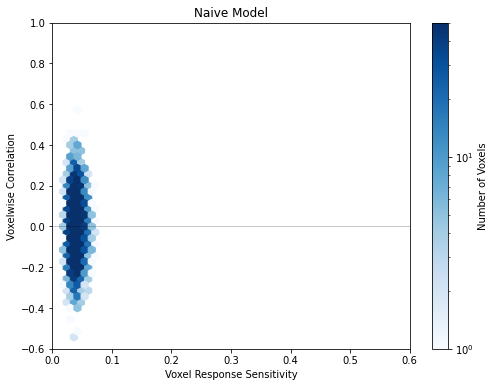

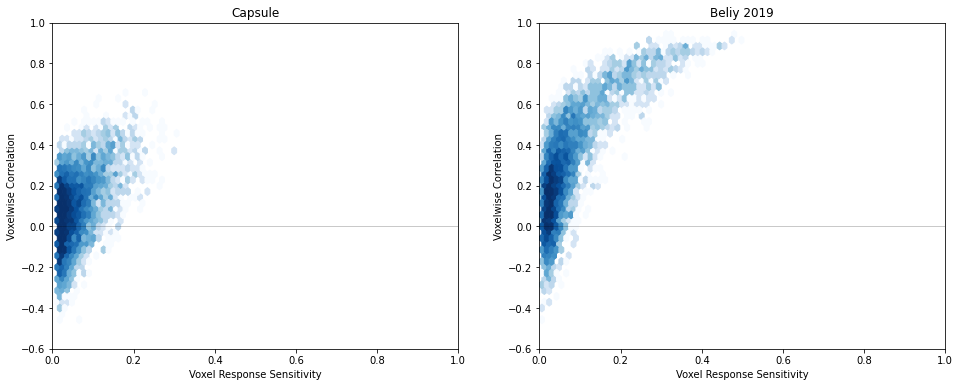

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hexbin(naive_rs_imagenet, naive_vc_imagenet, cmap='Blues', gridsize=50, bins='log', extent=(0, 0.6, -0.6, 1), vmax=50)
plt.xlim(0, 0.6)
plt.ylim(-0.6, 1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
cb = plt.colorbar(label='Number of Voxels') # colorbar is the same for all 3 plots
plt.xlabel('Voxel Response Sensitivity')
plt.ylabel('Voxelwise Correlation')
plt.title('Naive Model')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].hexbin(caps_imagenet_rs, caps_imagenet_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 0.6, -0.6, 1), vmax=50)
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[0].set_xlabel('Voxel Response Sensitivity')
axes[0].set_ylabel('Voxelwise Correlation')
axes[0].set_title('Capsule')

axes[1].hexbin(beliy_imagenet_rs, beliy_imagenet_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 0.6, -0.6, 1), vmax=50)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[1].set_xlabel('Voxel Response Sensitivity')
axes[1].set_ylabel('Voxelwise Correlation')
axes[1].set_title('Beliy 2019')
plt.setp(axes, xlim=(0, 1), ylim=(-0.6, 1)) # set axes limits for all subplots
plt.show()

================================================================================

================================================================================
#### Figure 4.5: Voxel RS vs Voxelwise Correlation on MNIST-fMRI

In [15]:
# Calculate voxelwise correlations and voxel response sensitivites for models trained on MNIST-fMRI

naive_mnist_vc = voxel_corr(naive_pred_mnist, y_test_mnist)
beliy_mnist_vc = voxel_corr(beliy_pred_mnist, y_test_mnist)
caps_mnist_vc = voxel_corr(caps_pred_mnist, y_test_mnist)
lcnn_mnist_vc = voxel_corr(lcnn_pred_mnist, y_test_mnist)

naive_mnist_rs = response_sensitivity(naive_pred_mnist, y_test_mnist)
beliy_mnist_rs = response_sensitivity(beliy_pred_mnist, y_test_mnist)
caps_mnist_rs = response_sensitivity(caps_pred_mnist, y_test_mnist)
lcnn_mnist_rs = response_sensitivity(lcnn_pred_mnist, y_test_mnist)

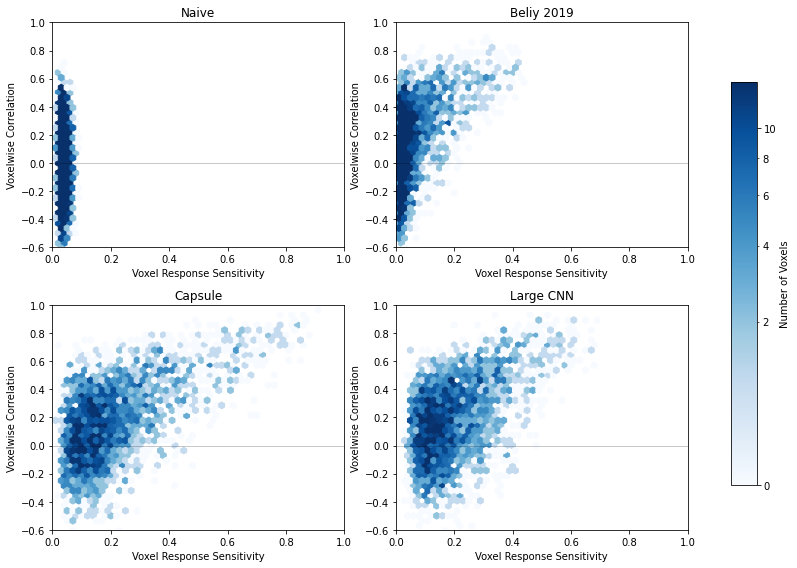

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].hexbin(naive_mnist_rs, naive_mnist_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 1, -1, 1), vmax=15)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[0, 0].set_xlabel('Voxel Response Sensitivity')
axes[0, 0].set_ylabel('Voxelwise Correlation')
axes[0, 0].set_title('Naive')

axes[0, 1].hexbin(beliy_mnist_rs, beliy_mnist_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 1, -1, 1), vmax=15)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[0, 1].set_xlabel('Voxel Response Sensitivity')
axes[0, 1].set_ylabel('Voxelwise Correlation')
axes[0, 1].set_title('Beliy 2019')


axes[1, 0].hexbin(caps_mnist_rs, caps_mnist_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 1, -1, 1), vmax=15)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[1, 0].set_xlabel('Voxel Response Sensitivity')
axes[1, 0].set_ylabel('Voxelwise Correlation')
axes[1, 0].set_title('Capsule')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_ylim(-0.6, 1)

hex = axes[1, 1].hexbin(lcnn_mnist_rs, lcnn_mnist_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 1, -1, 1), vmax=15)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
axes[1, 1].set_xlabel('Voxel Response Sensitivity')
axes[1, 1].set_ylabel('Voxelwise Correlation')
axes[1, 1].set_title('Large CNN')

plt.setp(axes, xlim=(0, 1), ylim=(-0.6, 1)) # set axes limits for all subplots
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb = fig.colorbar(hex, cax=cbar_ax, label='Number of Voxels')
# This is how I changed the tick labels of the color bars. Note that there was an offset of 1 between the tick value and the actual value
cb.minorticks_off()
cb.set_ticks([1, 11])
cb.set_ticklabels(['0','10'])
cb.set_ticks([3, 5, 7, 9], minor=True)
cb.set_ticklabels(['2', '4', '6', '8'], minor=True)
plt.show()


================================================================================

================================================================================
#### Introducing Response Weighted Correlation (RWC) and RWC Skew

Response weighted correlation (RWC) is a voxelwise metric that combines the pattern information from voxelwise correlation with the magnitude information from voxel response sensitivity (Voxel RS). RWC skew is a metric that measures the relative contributions of voxel response sensitivity versus voxelwise correlation to the RWC metric. The figures below visualize both of these metrics in the 2D plane of Voxel RS vs Voxel Corr using contours. Additionally we also demonstrate our RWC thresholding approach which calculates a unique RWC threshold for every combination of model/validation set. Using this approach, purple points are classified as intentional and grey points are classified as unintentional.

In [16]:
# RWC  Thresholding for beliy encoder trained on imagenet-fmri
beliy_rwc_imagenet = response_weighted_corr(beliy_pred_imagenet, y_test_imagenet)
beliy_thresh_imagenet = abs(np.min(beliy_rwc_imagenet))

# get indices of intentional and unintentional voxels
beliy_intent_imagenet = np.where(beliy_rwc_imagenet >= beliy_thresh_imagenet)[0]
beliy_unint_imagenet = np.where(beliy_rwc_imagenet < beliy_thresh_imagenet)[0]

In [17]:
# RWC Thresholding for beliy encoder trained on mnist-fmri
beliy_rwc_mnist = response_weighted_corr(beliy_pred_mnist, y_test_mnist)
beliy_thresh_mnist = abs(np.min(beliy_rwc_mnist))

# get indices of intentional and unintentional voxels

beliy_intent_mnist = np.where(beliy_rwc_mnist >= beliy_thresh_mnist)[0]
beliy_unint_mnist = np.where(beliy_rwc_mnist < beliy_thresh_mnist)[0]

/Users/scarere/venv/capsnet/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


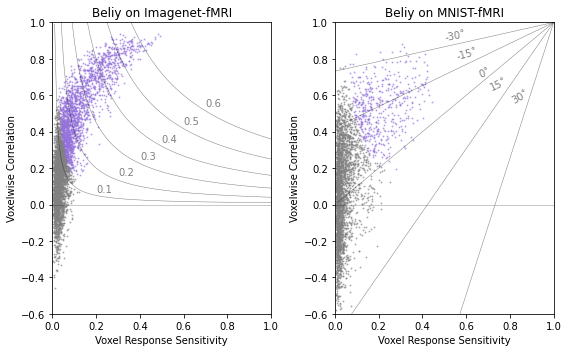

In [41]:
# Plot results
##########################################
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
# plot beliy on imagenet
axes[0].scatter(beliy_imagenet_rs[beliy_intent_imagenet], beliy_imagenet_vc[beliy_intent_imagenet], s=1, alpha=0.5, color='mediumpurple')
axes[0].scatter(beliy_imagenet_rs[beliy_unint_imagenet], beliy_imagenet_vc[beliy_unint_imagenet], s=1, alpha=0.5, color='gray')

# plot beliy on mnist
axes[1].scatter(beliy_mnist_rs[beliy_intent_mnist], beliy_mnist_vc[beliy_intent_mnist], s=1, alpha=0.5, color='mediumpurple')
axes[1].scatter(beliy_mnist_rs[beliy_unint_mnist], beliy_mnist_vc[beliy_unint_mnist], s=1, alpha=0.5, color='gray')

# plot RWC contours on top of imagenet plot
rwcs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
rs = np.linspace(0, 1, num=100)
for rwc in rwcs:
  t = (rwc**2)/rs # Calculate the voxel corr using voxel RS and the rwc value
  axes[0].plot(rs, t, color='black', alpha=0.5, linewidth=0.5)
  
# plot skew contours
skews = [30, 15, 0, -15, -30]
for skew in skews:
  a = skew+45 # angle of the line
  axes[1].plot([1, 1 - np.sqrt(4)*np.cos(a*np.pi/180)], [1, 1 - np.sqrt(4)*np.sin(a*np.pi/180)], color='black', alpha=0.5, linewidth=0.5)

# add text to contours
axes[0].text(0.2, 0.07, '0.1', alpha=0.5, fontsize=10)
axes[0].text(0.3, 0.16, '0.2', alpha=0.5, fontsize=10)
axes[0].text(0.4, 0.25, '0.3', alpha=0.5, fontsize=10)
axes[0].text(0.5, 0.34, '0.4', alpha=0.5, fontsize=10)
axes[0].text(0.6, 0.44, '0.5', alpha=0.5, fontsize=10)
axes[0].text(0.7, 0.54, '0.6', alpha=0.5, fontsize=10)

axes[1].text(0.50, 0.9, '-30˚', alpha=0.5, fontsize=10, rotation=10)
axes[1].text(0.55, 0.8, '-15˚', alpha=0.5, fontsize=10, rotation=15)
axes[1].text(0.65, 0.7, '0˚', alpha=0.5, fontsize=10, rotation=20)
axes[1].text(0.7, 0.63, '15˚', alpha=0.5, fontsize=10, rotation=25)
axes[1].text(0.8, 0.56, '30˚', alpha=0.5, fontsize=10, rotation=30)

axes[0].axhline(0, color='black', alpha=0.3, linewidth=0.7)
axes[1].axhline(0, color='black', alpha=0.3, linewidth=0.7)
axes[0].set_title('Beliy on Imagenet-fMRI')
axes[1].set_title('Beliy on MNIST-fMRI')
plt.setp(axes, xlim=(0, 1), ylim=(-0.6, 1), xlabel='Voxel Response Sensitivity', ylabel='Voxelwise Correlation') # set axes limits for all subplots
plt.tight_layout()
plt.show()

================================================================================
#### Figure 4.7: Comparison of RWC vs P-Value Thresholding

Show results from Figure 4.2 except color coded by which voxels are classified as intentional/unintentional and significant/insignificant in order to compare p-value and RWC thresholding. Note that the RWC and P-Value thresholds are calculated using the the model trained with all voxels

In [18]:
# Use p-value thresholding to get indices of significant and insignificant voxels 
# for voxels with positive voxelwise correlations
PVAL=0.001
beliy_imagenet_pvals = vc_pval(beliy_pred_imagenet, y_test_imagenet)
beliy_pv_imagenet_pvals = beliy_imagenet_pvals[pos_vox_subset]
beliy_pv_sig_imagenet = np.where(beliy_pv_imagenet_pvals <= PVAL)[0]
beliy_pv_insig_imagenet = np.where(beliy_pv_imagenet_pvals > PVAL)[0]

# Get indices of intentional and unintentional voxels for the positively correlated voxels
beliy_pv_rwc_imagenet = beliy_rwc_imagenet[pos_vox_subset]
beliy_pv_intent_imagenet = np.where(beliy_pv_rwc_imagenet >= beliy_thresh_imagenet)[0]
beliy_pv_unint_imagenet = np.where(beliy_pv_rwc_imagenet < beliy_thresh_imagenet)[0]

# Determine indices below both thresholds, above both, or above one but not the other
ab = beliy_pv_sig_imagenet[np.isin(beliy_pv_sig_imagenet, beliy_pv_intent_imagenet)] # above both thresholds
bb = beliy_pv_insig_imagenet[np.isin(beliy_pv_insig_imagenet, beliy_pv_unint_imagenet)] # below both thresholds
ap_brwc = beliy_pv_sig_imagenet[np.isin(beliy_pv_sig_imagenet, beliy_pv_unint_imagenet)] # above p-val thresh but below rwc thresh (significant yet unintentional)
bp_arwc = beliy_pv_insig_imagenet[np.isin(beliy_pv_insig_imagenet, beliy_pv_intent_imagenet)] # below p-val thresh but above rwc thresh (intentional yet insignificant)

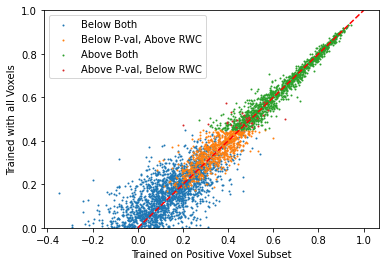

In [83]:
# Plot results
beliy_vc_pos = beliy_imagenet_vc[pos_vox_subset]
plt.scatter(beliy_pv_imagenet_vc[bb], beliy_vc_pos[bb], s=1)
plt.scatter(beliy_pv_imagenet_vc[bp_arwc], beliy_vc_pos[bp_arwc], s=1)
plt.scatter(beliy_pv_imagenet_vc[ab], beliy_vc_pos[ab], s=1)
plt.scatter(beliy_pv_imagenet_vc[ap_brwc], beliy_vc_pos[ap_brwc], s=1)
plt.legend(['Below Both', 'Below P-val, Above RWC', 'Above Both', 'Above P-val, Below RWC'])
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.xlim(-0.6, 1)
plt.ylim(0, 1)
plt.xlabel('Trained on Positive Voxel Subset')
plt.ylabel('Trained with all Voxels')
plt.show()

================================================================================
#### Table 4.3: Improved Metric Based Results on Imagenet-fMRI

In [99]:
from tabulate import tabulate
# Calculate new metrics for imagenet fMRI
b_int = get_int_vox_idx(beliy_pred_imagenet, y_test_imagenet)
c_int = get_int_vox_idx(caps_pred_imagenet, y_test_imagenet)
n_int = get_int_vox_idx(naive_pred_imagenet, y_test_imagenet)


model_preds = [naive_pred_imagenet, beliy_pred_imagenet, caps_pred_imagenet]
model_names = ['naive', 'beliy', 'capsule']
metrics = [rwc_mean, vc_mean, rs_mean]
metric_names = ['RWC', 'VC', 'RS']
v_int = np.union1d(b_int, c_int).astype(int)
v_int = np.union1d(v_int, n_int).astype(int)

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred[:, v_int], y_test_imagenet[:, v_int], metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
  table_text.append(row_text)

voxel_select = [n_int, b_int, c_int]
for i, model_pred in enumerate(model_preds):
    select = voxel_select[i]
    vals = draw_bs_replicate(model_pred[:, select], y_test_imagenet[:, select], rwc_skew_mean, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    rwc_text = '%f+-%f' % (mean, ci)
    table_text[i].insert(1, rwc_text)
    thresh = rwc_thresh(model_pred, y_test_imagenet)
    at_perc = above_thresh_percentage(model_pred, y_test_imagenet)
    t = '%f' % at_perc
    table_text[i].insert(0, t)
    t = '%f' % thresh
    table_text[i].insert(0, t)

metric_names = ['RWC_Thresh', 'Above Thresh (%)', 'RWC', 'RWC_Skew', 'VC', 'RS']
print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

╒═════════╤══════════════╤════════════════════╤═════════════════════╤══════════════════════╤═════════════════════╤════════════════════╕
│         │   RWC_Thresh │   Above Thresh (%) │ RWC                 │ RWC_Skew             │ VC                  │ RS                 │
╞═════════╪══════════════╪════════════════════╪═════════════════════╪══════════════════════╪═════════════════════╪════════════════════╡
│ naive   │     0.151188 │           0.043076 │ -0.000256+-0.000684 │ -17.715189+-2.149770 │ -0.001800+-0.002303 │ 0.038163+-0.000106 │
├─────────┼──────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼────────────────────┤
│ beliy   │     0.12261  │          42.1925   │ 0.260675+-0.006054  │ -18.273244+-0.930354 │ 0.531936+-0.019600  │ 0.131947+-0.003045 │
├─────────┼──────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼────────────────────┤
│ capsule │     0.176961 │           9.51971  │ 

================================================================================
#### Table 4.4: Improved Metric Based Results on MNIST-fMRI

In [100]:
from tabulate import tabulate
# Calculate new metrics for imagenet fMRI
b_int = get_int_vox_idx(beliy_pred_mnist, y_test_mnist)
c_int = get_int_vox_idx(caps_pred_mnist, y_test_mnist)
lcnn_int = get_int_vox_idx(lcnn_pred_mnist, y_test_mnist)
n_int = get_int_vox_idx(naive_pred_mnist, y_test_mnist)


model_preds = [naive_pred_mnist, beliy_pred_mnist, caps_pred_mnist, lcnn_pred_mnist]
model_names = ['naive', 'beliy', 'capsule', 'large_cnn']
metrics = [rwc_mean, vc_mean, rs_mean]
metric_names = ['RWC', 'VC', 'RS']
v_int = np.union1d(b_int, c_int).astype(int)
v_int = np.union1d(v_int, n_int).astype(int)
v_int = np.union1d(v_int, lcnn_int).astype(int)

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred[:, v_int], y_test_mnist[:, v_int], metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
  table_text.append(row_text)

voxel_select = [n_int, b_int, c_int, lcnn_int]
for i, model_pred in enumerate(model_preds):
    select = voxel_select[i]
    vals = draw_bs_replicate(model_pred[:, select], y_test_mnist[:, select], rwc_skew_mean, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    rwc_text = '%f+-%f' % (mean, ci)
    table_text[i].insert(1, rwc_text)
    thresh = rwc_thresh(model_pred, y_test_mnist)
    at_perc = above_thresh_percentage(model_pred, y_test_mnist)
    t = '%f' % at_perc
    table_text[i].insert(0, t)
    t = '%f' % thresh
    table_text[i].insert(0, t)

metric_names = ['RWC_Thresh', 'Above Thresh (%)', 'RWC', 'RWC_Skew', 'VC', 'RS']
print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

/Users/scarere/venv/capsnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scarere/venv/capsnet/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


╒═══════════╤══════════════╤════════════════════╤═════════════════════╤══════════════════════╤═════════════════════╤════════════════════╕
│           │   RWC_Thresh │   Above Thresh (%) │ RWC                 │ RWC_Skew             │ VC                  │ RS                 │
╞═══════════╪══════════════╪════════════════════╪═════════════════════╪══════════════════════╪═════════════════════╪════════════════════╡
│ naive     │     0.199186 │             0      │ -0.006686+-0.001875 │ nan+-nan             │ -0.011501+-0.005590 │ 0.035997+-0.000460 │
├───────────┼──────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼────────────────────┤
│ beliy     │     0.20899  │            15.4916 │ 0.265983+-0.024657  │ -15.599388+-1.815513 │ 0.493631+-0.028482  │ 0.179978+-0.014115 │
├───────────┼──────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼────────────────────┤
│ capsule   │     0.377117 │      

================================================================================
#### Figure 4.8: Effect of Validation SNR on Model Evaluation

Note the the RWC and P-Value thresholds are calculated using the low-SNR validation set with the model trained on all voxels

In [19]:
# create low-snr validation set by taking a single repeat
val_lowsnr = y_test_imagenet_lowsnr[:, 0, :]

beliy_imagenet_vc_lowsnr = voxel_corr(beliy_pred_imagenet, val_lowsnr)

# Calculate which voxels are above which thresholds
# Use p-value thresholding to get indices of significant and insignificant voxels 
# for voxels with positive voxelwise correlations
PVAL=0.001
beliy_imagenet_pvals_lowsnr = vc_pval(beliy_pred_imagenet, val_lowsnr)
beliy_sig_imagenet_lowsnr = np.where(beliy_imagenet_pvals_lowsnr <= PVAL)[0]
beliy_insig_imagenet_lowsnr = np.where(beliy_imagenet_pvals_lowsnr > PVAL)[0]

# Get indices of intentional and unintentional voxels for the positively correlated voxels
beliy_rwc_imagenet_lowsnr = response_weighted_corr(beliy_pred_imagenet, val_lowsnr)
beliy_thresh_imagenet_lowsnr = abs(np.min(beliy_rwc_imagenet_lowsnr))
beliy_intent_imagenet_lowsnr = np.where(beliy_rwc_imagenet_lowsnr >= beliy_thresh_imagenet_lowsnr)[0]
beliy_unint_imagenet_lowsnr = np.where(beliy_rwc_imagenet_lowsnr < beliy_thresh_imagenet_lowsnr)[0]

# Determine indices below both thresholds, above both, or above one but not the other
ab = beliy_sig_imagenet_lowsnr[np.isin(beliy_sig_imagenet_lowsnr, beliy_intent_imagenet_lowsnr)] # above both thresholds
bb = beliy_insig_imagenet_lowsnr[np.isin(beliy_insig_imagenet_lowsnr, beliy_unint_imagenet_lowsnr)] # below both thresholds
ap_brwc = beliy_sig_imagenet_lowsnr[np.isin(beliy_sig_imagenet_lowsnr, beliy_unint_imagenet_lowsnr)] # above p-val thresh but below rwc thresh (significant yet unintentional)
bp_arwc = beliy_insig_imagenet_lowsnr[np.isin(beliy_insig_imagenet_lowsnr, beliy_intent_imagenet_lowsnr)] # below p-val thresh but above rwc thresh (intentional yet insignificant)

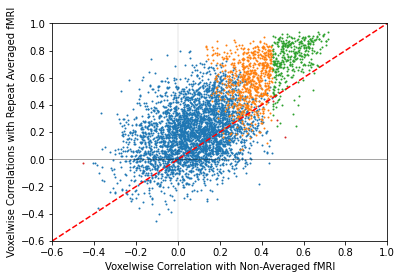

In [114]:
# Plot the results
plt.scatter(beliy_imagenet_vc_lowsnr[bb], beliy_imagenet_vc[bb], s=1)
plt.scatter(beliy_imagenet_vc_lowsnr[bp_arwc], beliy_imagenet_vc[bp_arwc], s=1)
plt.scatter(beliy_imagenet_vc_lowsnr[ab], beliy_imagenet_vc[ab], s=1)
plt.scatter(beliy_imagenet_vc_lowsnr[ap_brwc], beliy_imagenet_vc[ap_brwc], s=1)
plt.axhline(0, color='black', alpha=0.5, linewidth=0.7)
plt.axvline(0, color='black', alpha=0.5, linewidth=0.2)
plt.plot([-1, 1], [-1, 1], linestyle='--', color='red')
plt.xlim(-0.6, 1)
plt.ylim(-0.6, 1)
plt.xlabel('Voxelwise Correlation with Non-Averaged fMRI')
plt.ylabel('Voxelwise Correlations with Repeat Averaged fMRI')
plt.show()

---
---
## Appendix A: Supplementary Material


### A.2 - Existing Methods for Encoder Evaluation
---

#### Figure A.1: Voxelwise Correlation of Beliy Encoder on Imagenet-fMRI Projected onto Cortical Surface

In order to project the fMRI data onto the cortical surface, we used FreeSurfer, a popular neuroimaging softare. The documentation for freesurfer can be found [here](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferWiki). 

Once Freesurfer has been installed, and the necessary environment variables have been set, the first step is to reconstruct the cortical surface using the recon-all command. The documentation can be found [here](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all). If you have not already created a freesurfer subject directory for the subject whose cortex you are trying to reconstruct, using the -subject flag will automatically create one for you. Note that reconstructing the cortical surface can be computationally expensive and take a significant amount of time. You may wish to run autorecon in stages using the autorecon1, autorecon2 and autorecon3 flags. If I recall correctly, autorecon3 (steps 24-31) may not actually be needed to generate the surface files used to create the visualization in Figure A.1. Once the cortical surface has been reconstructed, one can project any MRI volume in nifti format (.nii.gz) to a surface file using the mri_vol2surf command, documenation can be found [here](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_vol2surf). This includes volumes that contain metrics such as response sensitivity or voxelwise correlation as opposed to fMRI activations. The parameters we used when projecting our volumes to the cortical surface are shown in the command below. Note the left and right hemispheres must be projected seperately.

```bash
    mri_vol2surf --mov path_to/3d_fmri_data.nii.gz --regheader  name_of_freesurfer_subject --hemi lh --surf white --projfrac-avg 0.1 0.9 0.1 --interp nearest --o name_of_output_surface_file.mgz
```

Note that the --mov flag is the same as the --src flag. This may be because my freesurfer version is outdated. Use the --help flag for more information on the command

#### Figure A.2: Voxelwise Correlation Advantage Plots

These are the visualizations used in the work by [St. Yves et al.](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305086)

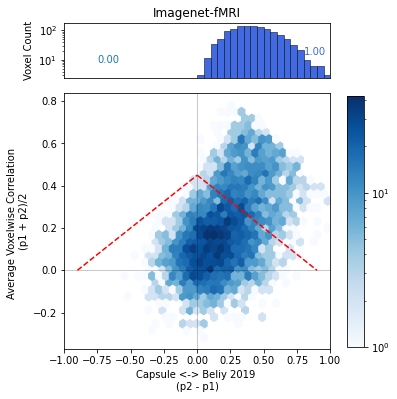

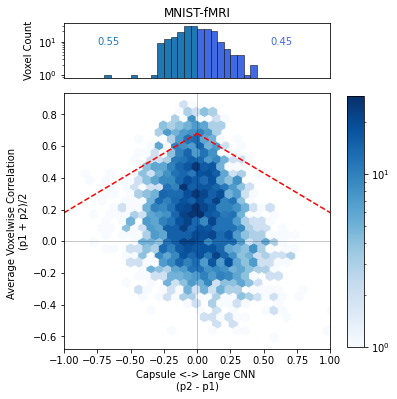

In [27]:
import matplotlib.pyplot as plt
# Compare Beliy encoder and Capsule encoder on Imagenet-fMRI
#===============================================================================

# Diff is our x-axis variable and avg is our y-axis variable
diff = beliy_imagenet_vc - caps_imagenet_vc
avg = (beliy_imagenet_vc + caps_imagenet_vc)/2

# get indices of voxels above significance threshold (for one or both models) 
# since these are the only voxels used in histogram
# 0.4514 corresponds to two-tailed significance of p=0.001 for a validation set with 50 samples
idx = np.where(np.maximum(beliy_imagenet_vc, caps_imagenet_vc) > 0.4514)

# determine percentage of significant voxels in idx that are on left or right 
# side of histogram. (left means capsule had higher vox corr, right means it had lower)
l = (diff[idx] < 0).sum()/len(diff[idx])
r = (diff[idx] > 0).sum()/len(diff[idx])

# Create Figure and a grid of subplots for the hexbin plot, histogram and colorbar
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, width_ratios=(7, 1), height_ratios=(1.5, 7), hspace=0.1)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0]) # axis for the hexbin plot
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) # axis for the histogram
ax_c = fig.add_axes([.78,.13,.04,.58]) # axis for the colorbar

# Create histogram
ax_histx.hist(diff[idx], bins=np.linspace(-1, 0, num=21), edgecolor='black', linewidth=0.5, color='tab:blue')
ax_histx.hist(diff[idx], bins=np.linspace(0, 1, num=21), edgecolor='black', linewidth=0.5, color='royalblue')
ax_histx.set_xlim(-1, 1)
ax_histx.tick_params(axis='x', which='both',
                bottom=False, labelbottom=False) # turn off xticks for histogram since it has same x-axis as hexbin plot
ax_histx.set_yscale('log')
ax_histx.set_ylabel('Voxel Count')
# add text labels outlining percent of significant voxels on each side of 0 on the x-axis
ax_histx.text(-0.75, 8, '%.2f' % (l), color='tab:blue')
ax_histx.text(0.8, 15, '%.2f' % (r), color='royalblue')
ax_histx.set_title('Imagenet-fMRI')

# Plot hexbin plot of diff vs avg
hex = ax.hexbin(diff, avg, cmap='Blues', gridsize=30, bins='log')
plt.colorbar(hex, cax=ax_c) # add colorbar
ax.axhline(y=0, color='black', alpha=0.3, linewidth=0.7)
ax.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
ax.set_xlim(-1, 1)
ax.set_xlabel('Capsule <-> Beliy 2019 \n(p2 - p1)')
ax.set_ylabel('Average Voxelwise Correlation \n(p1 + p2)/2')


# Plot lines that denote below being insignificant and above being significant.
# These values are derived from the threshold of 0.4514 which corresponds to p=0.001
# for this validation set. (ie. 50 samples, p=0.001, two-tailed)
ax.plot([-0.9, 0], [0, 0.45], '--', color='red')
ax.plot([0, 0.9], [0.45, 0], '--', color='red')
plt.show()

# Repeat process for capsule and large cnn encoders trained on MNIST-fMRI
#===============================================================================
# These two figures could probably be combined into a single figure to reduce repetitive code

# Diff is our x-axis variable and avg is our y-axis variable
diff = lcnn_mnist_vc - caps_mnist_vc
avg = (beliy_mnist_vc + caps_mnist_vc)/2

# get indices of voxels above significance threshold (for one or both models) 
# since these are the only voxels used in histogram
# 0.6788 corresponds to two-tailed significance of p=0.001 for a validation set with 20 samples
idx = np.where(np.maximum(lcnn_mnist_vc, caps_mnist_vc) > 0.6788)

# determine percentage of significant voxels in idx that are on left or right 
# side of histogram. (left means capsule had higher vox corr, right means it had lower)
l = (diff[idx] < 0).sum()/len(diff[idx])
r = (diff[idx] > 0).sum()/len(diff[idx])

# Create Figure and a grid of subplots for the hexbin plot, histogram and colorbar
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, width_ratios=(7, 1), height_ratios=(1.5, 7), hspace=0.1)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0]) # axis for the hexbin plot
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) # axis for the histogram
ax_c = fig.add_axes([.78,.13,.04,.58]) # axis for the colorbar

# Create histogram
ax_histx.hist(diff[idx], bins=np.linspace(-1, 0, num=21), edgecolor='black', linewidth=0.5, color='tab:blue')
ax_histx.hist(diff[idx], bins=np.linspace(0, 1, num=21), edgecolor='black', linewidth=0.5, color='royalblue')
ax_histx.set_xlim(-1, 1)
ax_histx.tick_params(axis='x', which='both',
                bottom=False, labelbottom=False) # turn off xticks for histogram since it has same x-axis as hexbin plot
ax_histx.set_yscale('log')
ax_histx.set_ylabel('Voxel Count')
# add text labels outlining percent of significant voxels on each side of 0 on the x-axis
ax_histx.text(-0.75, 8, '%.2f' % (l), color='tab:blue')
ax_histx.text(0.55, 8, '%.2f' % (r), color='royalblue')
ax_histx.set_title('MNIST-fMRI')

# Plot hexbin plot of diff vs avg
hex = ax.hexbin(diff, avg, cmap='Blues', gridsize=30, bins='log')
plt.colorbar(hex, cax=ax_c) # add colorbar
ax.axhline(y=0, color='black', alpha=0.3, linewidth=0.7)
ax.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
ax.set_xlim(-1, 1)
ax.set_xlabel('Capsule <-> Large CNN \n(p2 - p1)')
ax.set_ylabel('Average Voxelwise Correlation \n(p1 + p2)/2')


# Plot lines that denote below being insignificant and above being significant.
# These values are derived from the threshold of 0.6788 which corresponds to p=0.001
# for this validation set. (ie. 20 samples, p=0.001, two-tailed)
ax.plot([-1.36, 0], [0, 0.68], '--', color='red')
ax.plot([0, 1.36], [0.68, 0], '--', color='red')
plt.show()

### A.3 - Further Model Characterization
---

================================================================================
#### Figure A.3: RWC and Voxelwise Correlation for Different ROI's

In [39]:
# Calculate various metrics for specific roi's
caps_rwc_imagenet = response_weighted_corr(caps_pred_imagenet, y_test_imagenet)
roi_names = ['ROI_V1', 'ROI_V2', 'ROI_V3', 'ROI_V4', 'ROI_LOC', 'ROI_FFA', 'ROI_PPA', 'ROI_LVC', 'ROI_HVC']
roi_metrics_caps = {'rwc': [], 'vc': [], 'rs': []}
roi_metrics_beliy = {'rwc': [], 'vc': [], 'rs': []}
for roi in roi_names:
    select = handler.get_meta_field(roi).astype(bool) # Kamitani data handler object defined in methods section for loading data
    roi_metrics_caps['rwc'].append(caps_rwc_imagenet[select])
    roi_metrics_beliy['rwc'].append(beliy_rwc_imagenet[select])
    roi_metrics_caps['vc'].append(caps_imagenet_vc[select])
    roi_metrics_beliy['vc'].append(beliy_imagenet_vc[select])
    roi_metrics_caps['rs'].append(caps_imagenet_rs[select])
    roi_metrics_beliy['rs'].append(beliy_imagenet_rs[select])

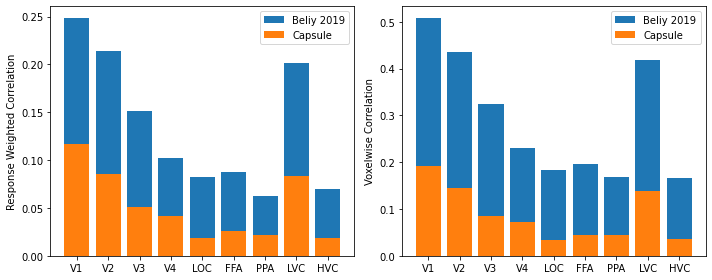

In [45]:
# Plot metrics for specific roi's
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# redefine roi_names for figure
roi_names = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA', 'LVC', 'HVC']

# plot rwc bar graph
axes[0].bar(roi_names, [np.mean(roi_metrics_beliy['rwc'][roi_index]) for roi_index in range(len(roi_names))])
axes[0].bar(roi_names, [np.mean(roi_metrics_caps['rwc'][roi_index]) for roi_index in range(len(roi_names))])
axes[0].set_ylabel('Response Weighted Correlation')
axes[0].legend(['Beliy 2019', 'Capsule'])

# plot voxel corr bar graph
axes[1].bar(roi_names, [np.mean(roi_metrics_beliy['vc'][roi_index]) for roi_index in range(len(roi_names))])
axes[1].bar(roi_names, [np.mean(roi_metrics_caps['vc'][roi_index]) for roi_index in range(len(roi_names))])
axes[1].legend(['Beliy 2019', 'Capsule'])
axes[1].set_ylabel('Voxelwise Correlation')

plt.tight_layout()
plt.show()

================================================================================
#### Figure A.4: Voxel Response Sensitivity vs Voxelwise Correlation with Training Set

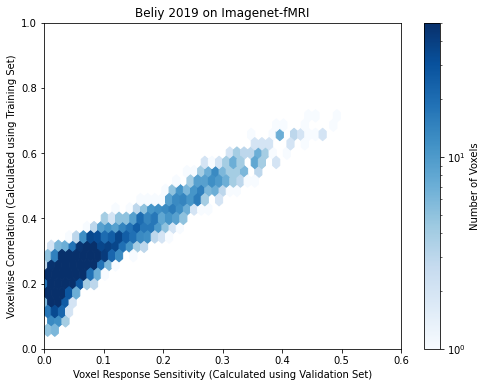

In [48]:
# load predictions of beliy encoder on training set
# Note that you'll have to unzip the provided predictions since the file size was too large for github
beliy_pred_imagenet_train = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pred_imagenet_train.csv'), delimiter=',')
beliy_imagenet_train_vc = voxel_corr(beliy_pred_imagenet_train, y_train_imagenet)
plt.figure(figsize=(8,6))
plt.hexbin(beliy_imagenet_rs, beliy_imagenet_train_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 0.6, -0.6, 1), vmax=50)
plt.xlim(0, 0.6)
plt.ylim(0, 1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
cb = plt.colorbar(label='Number of Voxels') # colorbar is the same for all 3 plots
plt.xlabel('Voxel Response Sensitivity (Calculated using Validation Set)')
plt.ylabel('Voxelwise Correlation (Calculated using Training Set)')
plt.title('Beliy 2019 on Imagenet-fMRI')
plt.show()

================================================================================
#### Figure A.5: Histogram of Voxelwise Correlations Catergorized by P-Value

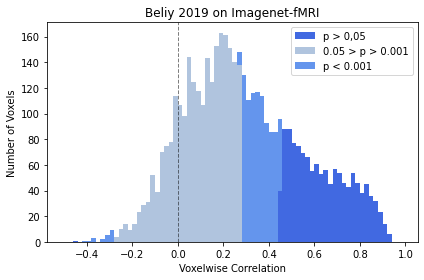

In [50]:

plt.hist(
  (
    beliy_imagenet_vc[np.where(beliy_imagenet_pvals < 0.001)], 
    beliy_imagenet_vc[np.where(beliy_imagenet_pvals > 0.05)], 
    beliy_imagenet_vc[np.where((beliy_imagenet_pvals< 0.05) & (beliy_imagenet_pvals > 0.001))]
  ), 
  bins=np.arange(-0.5, 1, 0.02), 
  stacked=True, 
  color=['royalblue', 'lightsteelblue', 'cornflowerblue'])

plt.xlabel('Voxelwise Correlation')
plt.ylabel('Number of Voxels')
plt.legend(['p > 0,05', '0.05 > p > 0.001', 'p < 0.001'])
plt.axvline(0, color='black', alpha=0.5, linewidth=1, linestyle='--')
plt.title('Beliy 2019 on Imagenet-fMRI')
plt.tight_layout()
plt.show()

================================================================================
#### Figure A.6: Robustness of Voxel Response Sensitivity

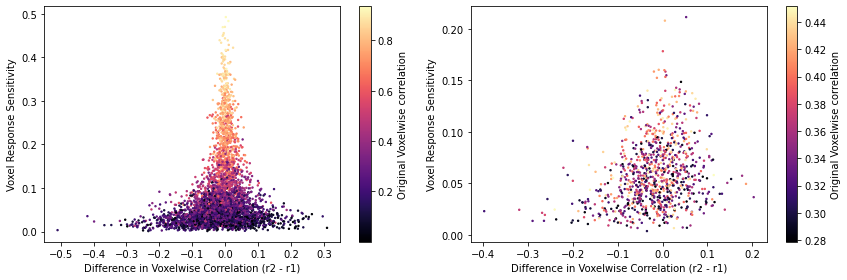

In [63]:
# vc2 = voxel_corr[np.where( (pvals < 0.05) & (pvals > 0.0001))[0]]
# bvcp2 = bvcp[np.where( (pvals < 0.05) & (pvals > 0.0001))]
# stdp2 = stdp[np.where( (pvals < 0.05) & (pvals > 0.0001))]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for all voxels
plot = axes[0].scatter(beliy_pv_imagenet_vc- beliy_imagenet_vc[pos_vox_subset], beliy_imagenet_rs[pos_vox_subset], s=2, c=beliy_imagenet_vc[pos_vox_subset], cmap='magma')
cbar = plt.colorbar(plot, ax=axes[0])
cbar.ax.set_ylabel('Original Voxelwise correlation')

# plot for only voxels with significance between 0.001 and 0.05
idx = np.where((beliy_pv_imagenet_pvals < 0.05) & (beliy_pv_imagenet_pvals > 0.001))[0]
plot = axes[1].scatter(beliy_pv_imagenet_vc[idx] - beliy_imagenet_vc[pos_vox_subset][idx], beliy_imagenet_rs[pos_vox_subset][idx], s=2, c=beliy_imagenet_vc[pos_vox_subset][idx], cmap='magma')
cbar = plt.colorbar(plot, ax=axes[1])
cbar.ax.set_ylabel('Original Voxelwise correlation')

plt.setp(axes, xlabel='Difference in Voxelwise Correlation (r2 - r1)', ylabel='Voxel Response Sensitivity') # set axes limits for all subplots
plt.tight_layout()
plt.show()

================================================================================
#### Figure A.7: Comparison of Voxelwise Correlation on Training and Validation Sets

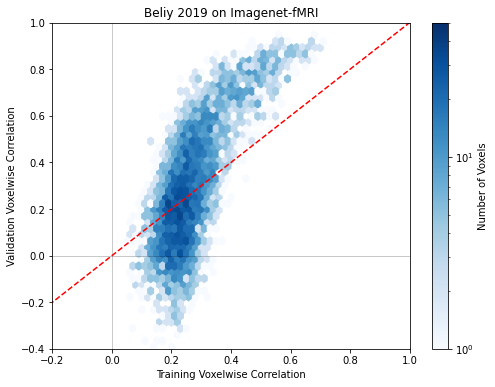

In [74]:
plt.figure(figsize=(8,6))
plt.hexbin(beliy_imagenet_train_vc, beliy_imagenet_vc, cmap='Blues', gridsize=50, bins='log', extent=(0, 1, -0.5, 1), vmax=50)
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
plt.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
plt.plot([-1, 1], [-1, 1], linestyle='--', color='red')
plt.xlim(-0.2, 1)
plt.ylim(-0.4, 1)
cb = plt.colorbar(label='Number of Voxels') # colorbar is the same for all 3 plots
plt.xlabel('Training Voxelwise Correlation')
plt.ylabel('Validation Voxelwise Correlation')
plt.title('Beliy 2019 on Imagenet-fMRI')
plt.show()

================================================================================
####  Figure A.8: Voxelwise Correlations with Predictions versus Repeated Measurements

In this experiment we correlate the low-snr measured brain activity with both repeated low-snr measurements, and the predicted brain activity. 

When correlating one low-snr fMRI measurement with other repeated low-snr measurements, we treat this as a measure of the consistency between measurements. If there was physiological or measurement noise, then repeated measurements would be exactly the same and have a correlation of 1. In order to obtain a robust estimate of the consistency between trials, we repeat this process 35 times, each time randomly choosing (with replacement) one of the other 34 repeated measurements. We then average the 35 correlation coefficients to obtain a more robust estimate of the consistency between trials. This is effectively a noise ceiling estimate.

Similarly, when calculating the correlation between the low-snr fMRI measurements and the predicted brain activity, we do this for each of the 35 repeated low-snr measurements (the predicted brain activity remains the same when calculating all correlation coefficients). We then average these 35 correlation coefficients to get our final estimate that we use on the x-axis

Note that all correlations in this experiment are voxelwise correlations. Additionally this experiment is done with the Imagenet-fMRI dataset since it is the only one that has a validation set with repeated measurements

In [76]:
vc_pred = [] # correlations between each fMRI measurement and predicted brain activity
vc_repeats = [] # correlations between repeated fMRI measurements
NUM_VOXELS = beliy_pred_imagenet.shape[1]
for v in range(NUM_VOXELS):
    vc_temp = []
    vc_temp2 = []
    for i in range(35):
        r = np.random.randint(1, 35) # use random int and circular indexing to select a random repeat other than oneself
        vc_temp.append(stats.pearsonr(y_test_imagenet_lowsnr[:, i, v], y_test_imagenet_lowsnr[:, (r+i)%35, v])[0])
        vc_temp2.append(stats.pearsonr(beliy_pred_imagenet[:, v], y_test_imagenet_lowsnr[:, i, v])[0])
    vc_repeats.append(vc_temp)
    vc_pred.append(vc_temp2)

vc_repeats = np.array(vc_repeats)
vc_pred = np.array(vc_pred)
print(vc_repeats.shape, vc_pred.shape)

(4643, 35) (4643, 35)


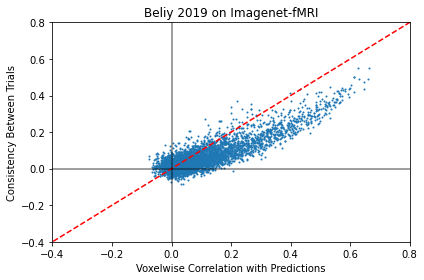

In [78]:
plt.scatter(np.mean(vc_pred, axis=1), np.mean(vc_repeats, axis=1), s=1) # note that we are averaging along the repeats axis which has a size of 35
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')
plt.xlim(-0.4,  0.8)
plt.ylim(-0.4, 0.8)
plt.axhline(0, alpha=0.5, color='black')
plt.axvline(0, alpha=0.5, color='black')
plt.xlabel('Voxelwise Correlation with Predictions')
plt.ylabel('Consistency Between Trials')
plt.title('Beliy 2019 on Imagenet-fMRI')
plt.tight_layout()
plt.show()

================================================================================
#### Figure A.9: Effect of Validation SNR for Different ROI's

Here we present the same results from Figure 4.8 except we separate voxels based on their ROI

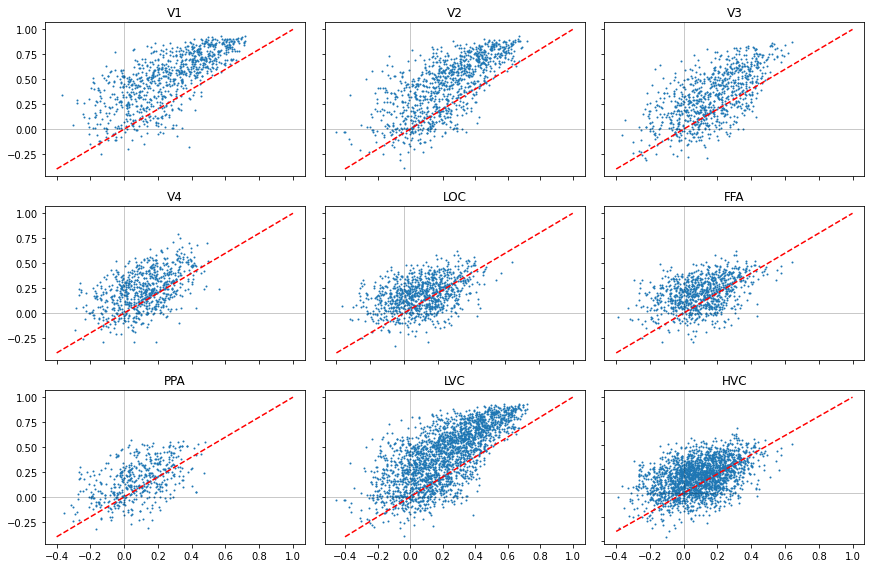

In [81]:
roi_names = ['ROI_V1', 'ROI_V2', 'ROI_V3', 'ROI_V4', 'ROI_LOC', 'ROI_FFA', 'ROI_PPA', 'ROI_LVC', 'ROI_HVC']
roi_names_short = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA', 'LVC', 'HVC']

# diffs = []
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flat
for i, roi in enumerate(roi_names):
    select = handler.get_meta_field(roi).astype(bool)
    axes[i].scatter(beliy_imagenet_vc_lowsnr[select], beliy_imagenet_vc[select], s=1)
    axes[i].plot([-0.4, 1], [-0.4, 1], '--', color='red')
    axes[i].axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
    axes[i].axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
    axes[i].set_title(roi_names_short[i])
    axes[i].label_outer()

plt.tight_layout()
plt.show()

---
---
## References

[1] T. Horikawa and Y. Kamitani, “Generic decoding of seen and imagined objects using hierarchical visual features,” Nature Communications, vol. 8, no. 1, Art. no. 1, May 2017, doi: 10.1038/ncomms15037.

[2] M. A. J. van Gerven, F. P. de Lange, and T. Heskes, “Neural Decoding with Hierarchical Generative Models,” Neural Computation, vol. 22, no. 12, pp. 3127–3142, Dec. 2010, doi: 10.1162/NECO_a_00047.